In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import axisartist
from mpl_toolkits.axes_grid1 import host_subplot
from scipy.stats import spearmanr
import datetime
from datetime import timedelta
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.frequent_patterns import apriori
import warnings
from scipy import stats
from sklearn import preprocessing, metrics, svm
from sklearn.linear_model import LogisticRegression
import os
warnings.filterwarnings('ignore')
pd.set_option('display.min_rows', 30)
pd.set_option('display.max_rows',150)
pd.set_option('display.width', 1000)

# Useful classes to have easier access to data features
class ColumnsInput:
    barcode = 'ddc_barcode'
    ipcode = 'ddc_ipcode'
    machine = 'ddc_mch_code'
    machine_side = 'ddc_mch_side'
    event = 'ddc_ev_subcode'
    time = 'ddc_ev_timestamp'
    
    
class ColumnsOutput:
    c_machine = 'c_machine' 
    event_delta_time = 'event_delta_time'
    day = 'y-m-day'
    month = 'month'
    status = 'status'

file_list = os.listdir('Data/data_per_machine/2021/')
print(file_list)
mach_name = [file.replace('.csv','') for file in file_list]
print(mach_name, len(mach_name))

['C403.csv', 'C103.csv', '1506.csv', 'C305.csv', 'C105.csv', 'C211.csv', '1306.csv', 'C603.csv', 'C210.csv', 'C605.csv', '1302.csv', '1501.csv', '1206.csv', 'C404.csv', '1402.csv', 'C207.csv', '1304.csv', '1406.csv', 'C511.csv', '1305.csv', '1301.csv', 'C608.csv', 'C612.csv', 'C209.csv', '1502.csv', '1403.csv', '1303.csv', 'C410.csv', 'C502.csv', 'C501.csv', '1507.csv', 'C407.csv', 'C412.csv', '1205.csv', 'C508.csv', '1404.csv', 'C303.csv', 'C111.csv', 'C610.csv', '1307.csv', 'C110.csv', 'C308.csv', 'C309.csv', 'C503.csv', '1407.csv', 'C202.csv', 'C509.csv', '1401.csv', 'C104.csv', 'C406.csv', '1203.csv', 'C601.csv', '1505.csv', 'C408.csv', 'C205.csv', 'C602.csv', 'C203.csv', 'C204.csv', 'C607.csv', 'C510.csv', 'C301.csv', 'C206.csv', 'C310.csv', 'C311.csv', 'C109.csv', '1201.csv', 'C411.csv', 'C512.csv', 'C405.csv', 'C401.csv', 'C505.csv', 'C201.csv', 'C302.csv', 'C606.csv', 'C609.csv', '1503.csv', 'C506.csv', 'C304.csv', 'C208.csv', '1405.csv', 'C107.csv', '1504.csv', '1202.csv', 'C1

In [3]:
def general_plot(x_, y_, x_bounds = None, y_bounds = None, title = None, x_title = None, y_title = None):
    fig, ax = plt.subplots(figsize=(15, 4))

    plt.xticks(rotation=90)
    plt.grid(True)
    
    if title is not None:
        plt.title(title)
    
    if x_title is not None:    
        plt.xlabel(x_title)
        
    if y_title is not None:    
        plt.ylabel(y_title)
    
    if (x_bounds is not None):
        plt.xlim(x_bounds)
               
    if (y_bounds is not None):
        plt.ylim(y_bounds)
    ax.plot(x_,y_, 'bo')
    
    plt.show()

In [11]:
mach_index = 0
df = pd.read_csv('Data/data_per_machine/2021/' + file_list[mach_index])
df[ColumnsInput.time] = pd.to_datetime(df[ColumnsInput.time])
current_machine = mach_name[mach_index]
df.head()

,Unnamed: 0,ddc_barcode,ddc_ipcode,ddc_mch_code,ddc_mch_side,ddc_ev_subcode,ddc_ev_timestamp,c_machine,month,y-m-day
0,1108,9436961295,24926,C403,L,LO_LOADER_IN_PRESS,2021-12-17 22:17:12,True,12,21-12-17
1,1109,9436961294,24926,C403,R,LO_LOADER_IN_PRESS,2021-12-17 22:17:12,True,12,21-12-17
2,1120,9436961295,24926,C403,L,LO_BLADDER_PRESHAPING,2021-12-17 22:17:18,True,12,21-12-17
3,1121,9436961294,24926,C403,R,LO_BLADDER_PRESHAPING,2021-12-17 22:17:18,True,12,21-12-17
4,1126,9436961295,24926,C403,L,LO_BLADDER_VACUUM,2021-12-17 22:17:23,True,12,21-12-17


In [50]:
working_time_per_day = df.groupby([ColumnsOutput.day])[ColumnsInput.time].agg(['min', 'max']).reset_index()
working_time_per_day['work_time'] = (working_time_per_day['max'] - working_time_per_day['min']).dt.total_seconds()
print(working_time_per_day.head())

working_time_per_day_per_arm = df.groupby([ColumnsOutput.day, ColumnsInput.machine_side])[ColumnsInput.time].agg(['min', 'max']).reset_index()
working_time_per_day_per_arm['work_time'] = (working_time_per_day_per_arm['max'] - working_time_per_day_per_arm['min']).dt.total_seconds()
print(working_time_per_day_per_arm.head())
df_right = working_time_per_day_per_arm[working_time_per_day_per_arm[ColumnsInput.machine_side] == 'R']
df_left = working_time_per_day_per_arm[working_time_per_day_per_arm[ColumnsInput.machine_side] == 'L']


    y-m-day                 min                 max  work_time
0  21-12-17 2021-12-17 22:17:12 2021-12-17 23:59:58     6166.0
1  21-12-18 2021-12-18 00:00:01 2021-12-18 23:59:54    86393.0
2  21-12-19 2021-12-19 00:00:06 2021-12-19 23:58:51    86325.0
3  21-12-20 2021-12-20 00:13:50 2021-12-20 02:12:13     7103.0
4  21-12-21 2021-12-21 00:30:09 2021-12-21 01:45:59     4550.0
    y-m-day ddc_mch_side                 min                 max  work_time
0  21-12-17            L 2021-12-17 22:17:12 2021-12-17 23:59:58     6166.0
1  21-12-17            R 2021-12-17 22:17:12 2021-12-17 23:59:58     6166.0
2  21-12-18            L 2021-12-18 00:00:01 2021-12-18 23:59:52    86391.0
3  21-12-18            R 2021-12-18 00:00:01 2021-12-18 23:59:54    86393.0
4  21-12-19            L 2021-12-19 00:00:06 2021-12-19 22:52:48    82362.0


In [ ]:
mach_tyre_per_day = df.groupby([ColumnsInput.machine, ColumnsOutput.day]).agg({ColumnsInput.barcode: 'count'}).reset_index()
mach_tyre_per_day = mach_tyre_per_day.rename(columns={ColumnsInput.barcode: 'tyre_count'})


  ddc_mch_code   y-m-day  ddc_barcode
0         C403  21-12-17          330
1         C403  21-12-18         4352
2         C403  21-12-19         3378
3         C403  21-12-20          227
4         C403  21-12-21          105


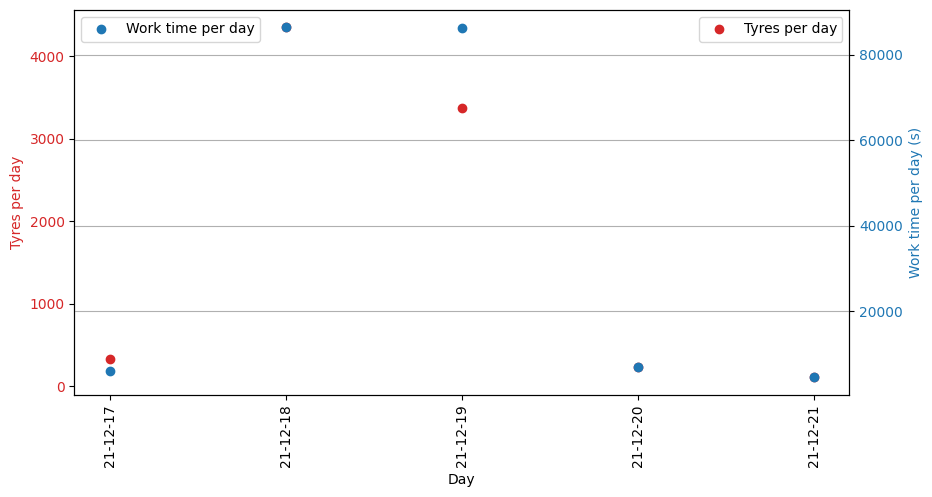

In [47]:

print(mach_tyre_per_day)
figure, ax_left = plt.subplots(figsize=(10, 5)) 

color = 'tab:red'
ax_left.set_xticklabels(mach_tyre_per_day[ColumnsOutput.day], rotation=90)
ax_left.set_ylabel('Tyres per day', color=color)
ax_left.set_xlabel('Day')
ax_left.plot(mach_tyre_per_day[ColumnsOutput.day], mach_tyre_per_day[ColumnsInput.barcode], 'bo', label = 'Tyres per day', color=color)
ax_left.tick_params(axis='y', labelcolor=color)
ax_left.legend(loc='upper right')
color = 'tab:blue'
ax_right = ax_left.twinx()
ax_right.set_ylabel('Work time per day (s)', color=color)
ax_right.plot(working_time_per_day[ColumnsOutput.day], working_time_per_day['work_time'], 'ro', label = 'Work time per day', color=color)
ax_right.tick_params(axis='y', labelcolor=color)
plt.legend(loc='upper left')
plt.grid(axis='x')
plt.grid(axis='y')
plt.grid(True)
plt.show()


In [ ]:
mach_tyre_per_day = mach_tyre_per_day.sort_values(by=[ColumnsInput.barcode])
print(mach_tyre_per_day)
for row in range(len(mach_tyre_per_day)):
    mach_tyre_per_day[ColumnsInput.barcode][row]
    print(mach_tyre_per_day[ColumnsOutput.day][row], mach_tyre_per_day[ColumnsInput.barcode][row])

  ddc_mch_code   y-m-day  ddc_barcode
4         C403  21-12-21          105
3         C403  21-12-20          227
0         C403  21-12-17          330
2         C403  21-12-19         3378
1         C403  21-12-18         4352
21-12-17 330
21-12-18 4352
21-12-19 3378
21-12-20 227
21-12-21 105


In [ ]:
mean_n_tyre_per_day = mach_tyre_per_day[ColumnsInput.barcode].mean()
for i in range(len(mach_tyre_per_day)):
    if mach_tyre_per_day[ColumnsInput.barcode][i] <=  mean_n_tyre_per_day:
        print('Machine '+str(current_machine)+ " in day " +mach_tyre_per_day[ColumnsOutput.day][i] +' is underperforming')
        df.drop(df[df[ColumnsOutput.day] == mach_tyre_per_day[ColumnsOutput.day][i]].index, inplace = True)

Machine C403 in day 21-12-17 is underperforming
Machine C403 in day 21-12-20 is underperforming
Machine C403 in day 21-12-21 is underperforming


In [ ]:
last_indexes = df.sort_values(ColumnsInput.time).groupby(ColumnsInput.barcode)[ColumnsInput.event].agg(['last']).reset_index()
first_indexes = df.sort_values(ColumnsInput.time).groupby(ColumnsInput.barcode)[ColumnsInput.event].agg('first').reset_index()
first_last_indexes = df.sort_values(ColumnsInput.time).groupby(ColumnsInput.barcode)[ColumnsInput.event].agg(['first', 'last']).reset_index()
print(len(last_indexes))
print(len(first_indexes))
first_last_indexes

223
223


,ddc_barcode,first,last
0,9436961464,LO_LOADER_IN_PRESS,UN_FORK_OUT
1,9436961465,LO_LOADER_IN_PRESS,UN_FORK_OUT
2,9436961466,LO_LOADER_IN_PRESS,UN_FORK_OUT
3,9436961467,LO_LOADER_IN_PRESS,UN_FORK_OUT
4,9436961468,OP_PRESS_STOP_PAUSE_3,UN_FORK_OUT
5,9436961469,LO_LOADER_IN_PRESS,UN_FORK_OUT
6,9436961470,OP_PRESS_STOP_PAUSE_3,UN_FORK_OUT
7,9436961471,LO_LOADER_IN_PRESS,UN_TCR_DOWN
8,9436962002,LO_LOADER_IN_PRESS,UN_FORK_OUT
9,9436962003,LO_LOADER_IN_PRESS,UN_FORK_OUT


In [ ]:
first_last_indexes[ColumnsOutput.status] = False
print(first_last_indexes.columns)
starting_event = ["LO_LOADER_IN_PRESS", "LO_LOADER_IN_PRESS_START"]
ending_event = ["UN_UNLOADER_OUT", "UN_FORK_OUT", "UN_UNLOADER_OUT_STOP", "UN_FORK_OUT_STOP"]

first_last_indexes[ColumnsOutput.status] = first_last_indexes.apply(lambda x: 'CYCLE_COMPLETED' if x['last'] in ending_event else 'CYCLE_ABORTED' if x['first'] in starting_event else 'CYCLE_NOT_STARTED', axis=1)
first_last_indexes.value_counts(ColumnsOutput.status)
first_last_indexes

Index(['ddc_barcode', 'first', 'last', 'status'], dtype='object')


,ddc_barcode,first,last,status
0,9436961464,LO_LOADER_IN_PRESS,UN_FORK_OUT,CYCLE_COMPLETED
1,9436961465,LO_LOADER_IN_PRESS,UN_FORK_OUT,CYCLE_COMPLETED
2,9436961466,LO_LOADER_IN_PRESS,UN_FORK_OUT,CYCLE_COMPLETED
3,9436961467,LO_LOADER_IN_PRESS,UN_FORK_OUT,CYCLE_COMPLETED
4,9436961468,OP_PRESS_STOP_PAUSE_3,UN_FORK_OUT,CYCLE_COMPLETED
5,9436961469,LO_LOADER_IN_PRESS,UN_FORK_OUT,CYCLE_COMPLETED
6,9436961470,OP_PRESS_STOP_PAUSE_3,UN_FORK_OUT,CYCLE_COMPLETED
7,9436961471,LO_LOADER_IN_PRESS,UN_TCR_DOWN,CYCLE_ABORTED
8,9436962002,LO_LOADER_IN_PRESS,UN_FORK_OUT,CYCLE_COMPLETED
9,9436962003,LO_LOADER_IN_PRESS,UN_FORK_OUT,CYCLE_COMPLETED


<Axes: xlabel='status'>

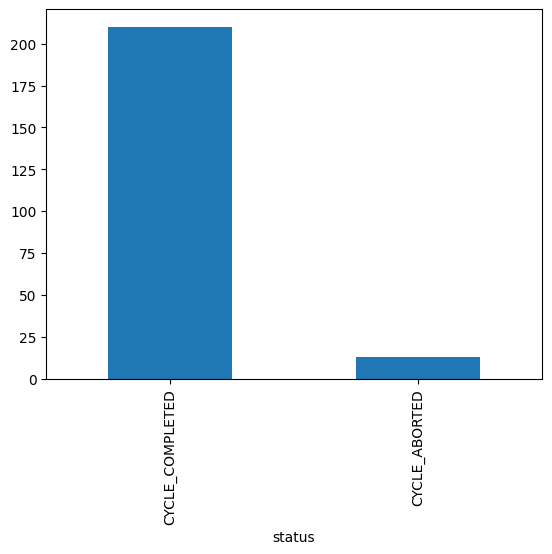

In [ ]:
first_last_indexes[ColumnsOutput.status].value_counts().plot(kind='bar')    